In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision.transforms import v2

from CustomDataset import NyuDataset
from CustomLoss import Loss_fn
from Models import DensenetBased
from Utils import functions

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [2]:
BATCH_SIZE = 8

# adjust acording to architecture and memory constraints
image_shape = (240, 320)
depth_shape = (120, 160)

nyu_train = NyuDataset(
    train_data=True,
    inverse_depth=True,
    image_shape=image_shape,
    depth_shape=depth_shape,
    transforms=v2.Compose([
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ])
)

nyu_test = NyuDataset(
    train_data=False,
    inverse_depth=True,
    image_shape=image_shape,
    depth_shape=depth_shape,
    transforms=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
)

nyu_train_visualizer = NyuDataset(
    train_data=True,
    inverse_depth=True,
    image_shape=image_shape,
    depth_shape=depth_shape,
    transforms=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
)

nyu_test_visualizer = NyuDataset(
    train_data=False,
    inverse_depth=True,
    image_shape=image_shape,
    depth_shape=depth_shape,
    transforms=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
)

train_dataloader = DataLoader(
    nyu_train,
    batch_size=BATCH_SIZE,
    num_workers=4,
    persistent_workers=True,
    # prefetch_factor=2,
)

test_dataloader = DataLoader(
    nyu_test,
    batch_size=BATCH_SIZE,
    num_workers=4,
    persistent_workers=True,
    # prefetch_factor=2,
)

train_visualizer = DataLoader(
    nyu_train_visualizer,
    batch_size=1,
    num_workers=1
)

test_visualizer = DataLoader(
    nyu_test_visualizer,
    batch_size=1,
    num_workers=1
)

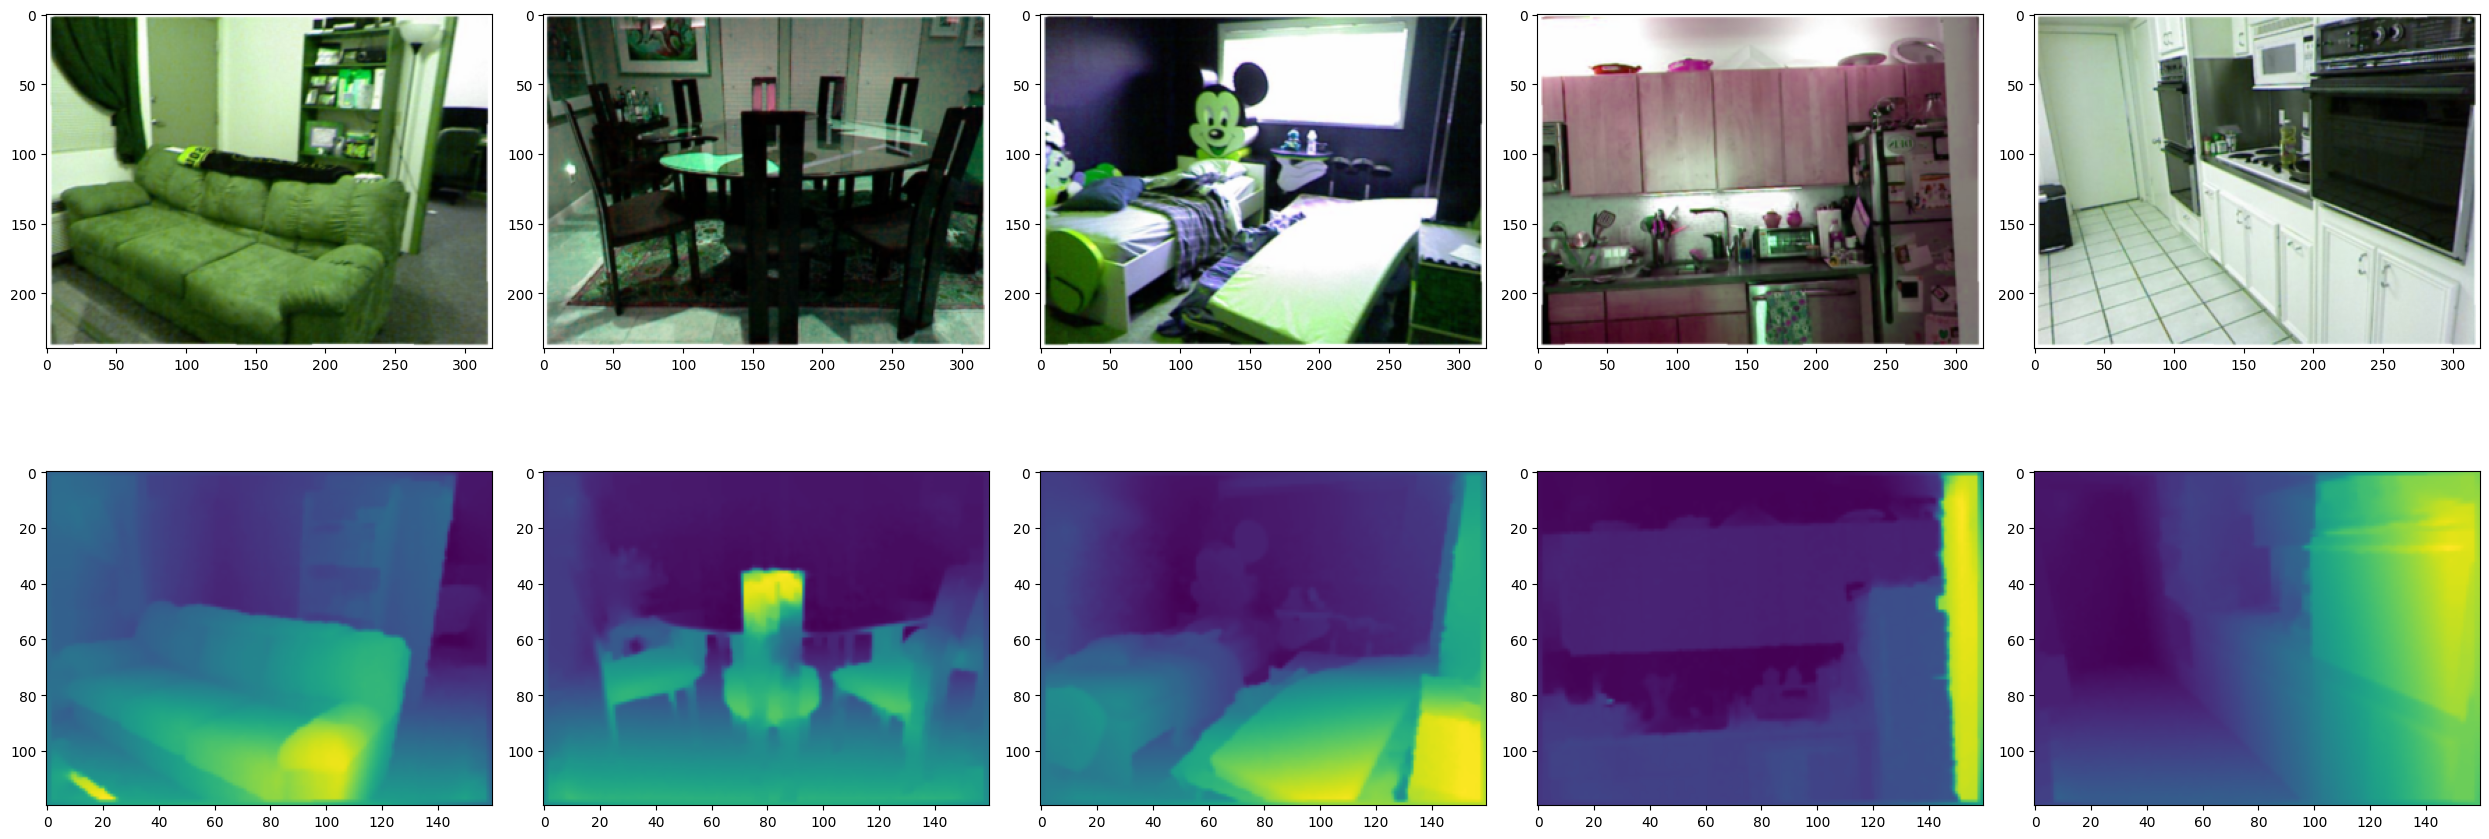

In [3]:
N = 5

fig, axs = plt.subplots(2, N, figsize=(5*N, 10))

for i in range(N):
    images = nyu_train[i]
    axs[0, i].imshow(images[0].permute(1, 2, 0))
    axs[1, i].imshow(images[1].permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [4]:
images[0].permute(1, 2, 0).shape

torch.Size([240, 320, 3])

In [5]:
A = set(nyu_train.indices) & set(nyu_test.indices)
print(len(A))   # has to be 0

0


In [6]:
# class DepthEstimator(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

#         self.encode1 = nn.Sequential(
#             # double conv
#             nn.Conv2d(
#                 in_channels=3, out_channels=16,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=16, out_channels=16,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             # nn.BatchNorm2d(64),
#         )

#         self.encode2 = nn.Sequential(
#             # double conv
#             nn.Conv2d(
#                 in_channels=16, out_channels=64,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=64, out_channels=64,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             # nn.BatchNorm2d(256),
#         )

#         self.encode3 = nn.Sequential(
#             # double conv
#             nn.Conv2d(
#                 in_channels=64, out_channels=256,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=256, out_channels=256,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             # nn.BatchNorm2d(1024),
#         )

#         self.decode1 = nn.Sequential(
#             nn.ConvTranspose2d(
#                 in_channels=256, out_channels=64,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#         )

#         self.decode2 = nn.Sequential(
#             nn.ConvTranspose2d(
#                 in_channels=128, out_channels=16,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#         )

#         self.decode3 = nn.Sequential(
#             nn.ConvTranspose2d(
#                 in_channels=32, out_channels=4,
#                 kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#         )

#         self.conv1 = nn.Conv2d(4, 1, 1)

#     def forward(self, x):
#         x1 = self.encode1(x)
#         x1 = self.maxpool(x1)
#         x2 = self.encode2(x1)
#         x2 = self.maxpool(x2)
#         x3 = self.encode3(x2)

#         d1 = self.decode1(x3)
#         d2 = self.decode2(torch.cat([x2, d1], dim=1))
#         d2 = self.upsample(d2)
#         d3 = self.decode3(torch.cat([x1, d2], dim=1))
#         d3 = self.upsample(d3)
#         return self.conv1(d3)

In [7]:
model = DensenetBased.DepthEstimator()

for name, param in model.named_parameters():    # freeze base densnet model
    if name.startswith("encoder"):
        param.requires_grad = False


model.to(DEVICE)
model.train()

pred_shape = functions.model_in_out_shape(model=model, input_shape=[1, 3, 240, 320], DEVICE=DEVICE)
print(pred_shape)

NUM_EPOCHS = 20
LR = 1e-4
MIN_LR = 1e-5
MOMENTUM = 0.8

all_train_loss = []
all_test_loss = []
all_lr = []

min_test_loss = float('inf')

OPTIMIZER = optim.Adam(model.parameters(), lr=LR)
# SCHEDULER = optim.lr_scheduler.CosineAnnealingLR(OPTIMIZER, NUM_EPOCHS, MIN_LR)

torch.Size([1, 1, 120, 160])


In [8]:
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()

    # unfreeze encoder net
    if epoch == 2:
        for name, param in model.named_parameters():
            if name.startswith("encoder"):
                param.requires_grad = True

    total_train_loss = 0

    for img, lbl in tqdm(train_dataloader):

        img, lbl = img.to(DEVICE), lbl.to(DEVICE)

        pred = model(img)

        OPTIMIZER.zero_grad()

        loss = Loss_fn(pred, lbl, 0.1, 1, 1)
        loss.backward()

        total_train_loss += loss.item()

        OPTIMIZER.step()

    # SCHEDULER.step()

    model.eval()

    total_test_loss = 0

    for img, lbl in tqdm(test_dataloader):
        with torch.no_grad():

            img, lbl = img.to(DEVICE), lbl.to(DEVICE)

            pred = model(img)

            loss = Loss_fn(pred, lbl, 0.1, 1, 1)

            total_test_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    all_train_loss.append(avg_train_loss)
    print("train_loss:", avg_train_loss)

    avg_test_loss = total_test_loss / len(test_dataloader)
    all_test_loss.append(avg_test_loss)
    print("test_loss:", avg_test_loss)

    if avg_test_loss < min_test_loss:
        torch.save(model.state_dict(), r"last_best_model_normalized_inverse_depth.pt")

    # all_lr.append(SCHEDULER.get_last_lr())

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.13504982047428296
test_loss: 0.11657056971029801


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.11367147386543394
test_loss: 0.11203098879619078


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.10287480003486468
test_loss: 0.09622567045417699


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.0892255404802758
test_loss: 0.09769564331932501


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.0822574416776811
test_loss: 0.09172100478952581


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.07651079985804445
test_loss: 0.09284641830758615


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.07067746883184892
test_loss: 0.08894331245259805


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.06568552741384882
test_loss: 0.08450996178117666


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.06156049161328105
test_loss: 0.08445969345894727


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.06055224434597286
test_loss: 0.08670988895676353


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.059829399840334266
test_loss: 0.0964874155819416


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.5519802051442345
test_loss: 0.6076463867317546


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.14701750522523416
test_loss: 0.15619868473573165


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.10772463327317726
test_loss: 0.10383176641030745


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.094647897598077
test_loss: 0.09463842687281696


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.0853714926505652
test_loss: 0.09683804959058762


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.0795112133436785
test_loss: 0.09567129835486413


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.074489839756348
test_loss: 0.0887017277831381


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.07027147214595728
test_loss: 0.08693603311072697


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

train_loss: 0.066896357903565
test_loss: 0.08302422287789259


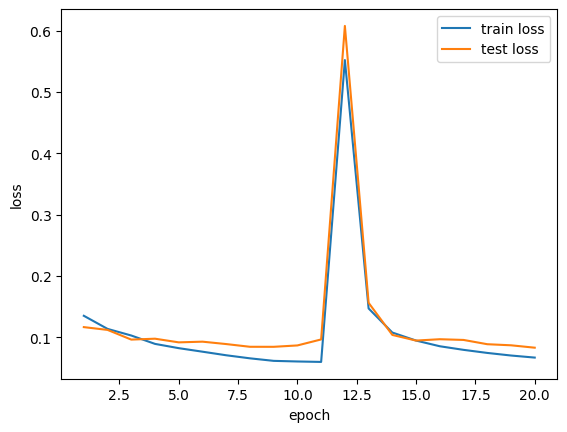

In [9]:
plt.plot([x+1 for x in range(len(all_train_loss))], np.array(all_train_loss), label="train loss")
plt.plot([x+1 for x in range(len(all_test_loss))], np.array(all_test_loss), label="test loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [10]:
# plt.plot([x+1 for x in range(len(all_lr))], all_lr, label="lr")
# plt.ylabel("learning rate")
# plt.xlabel("epoch")
# plt.show()

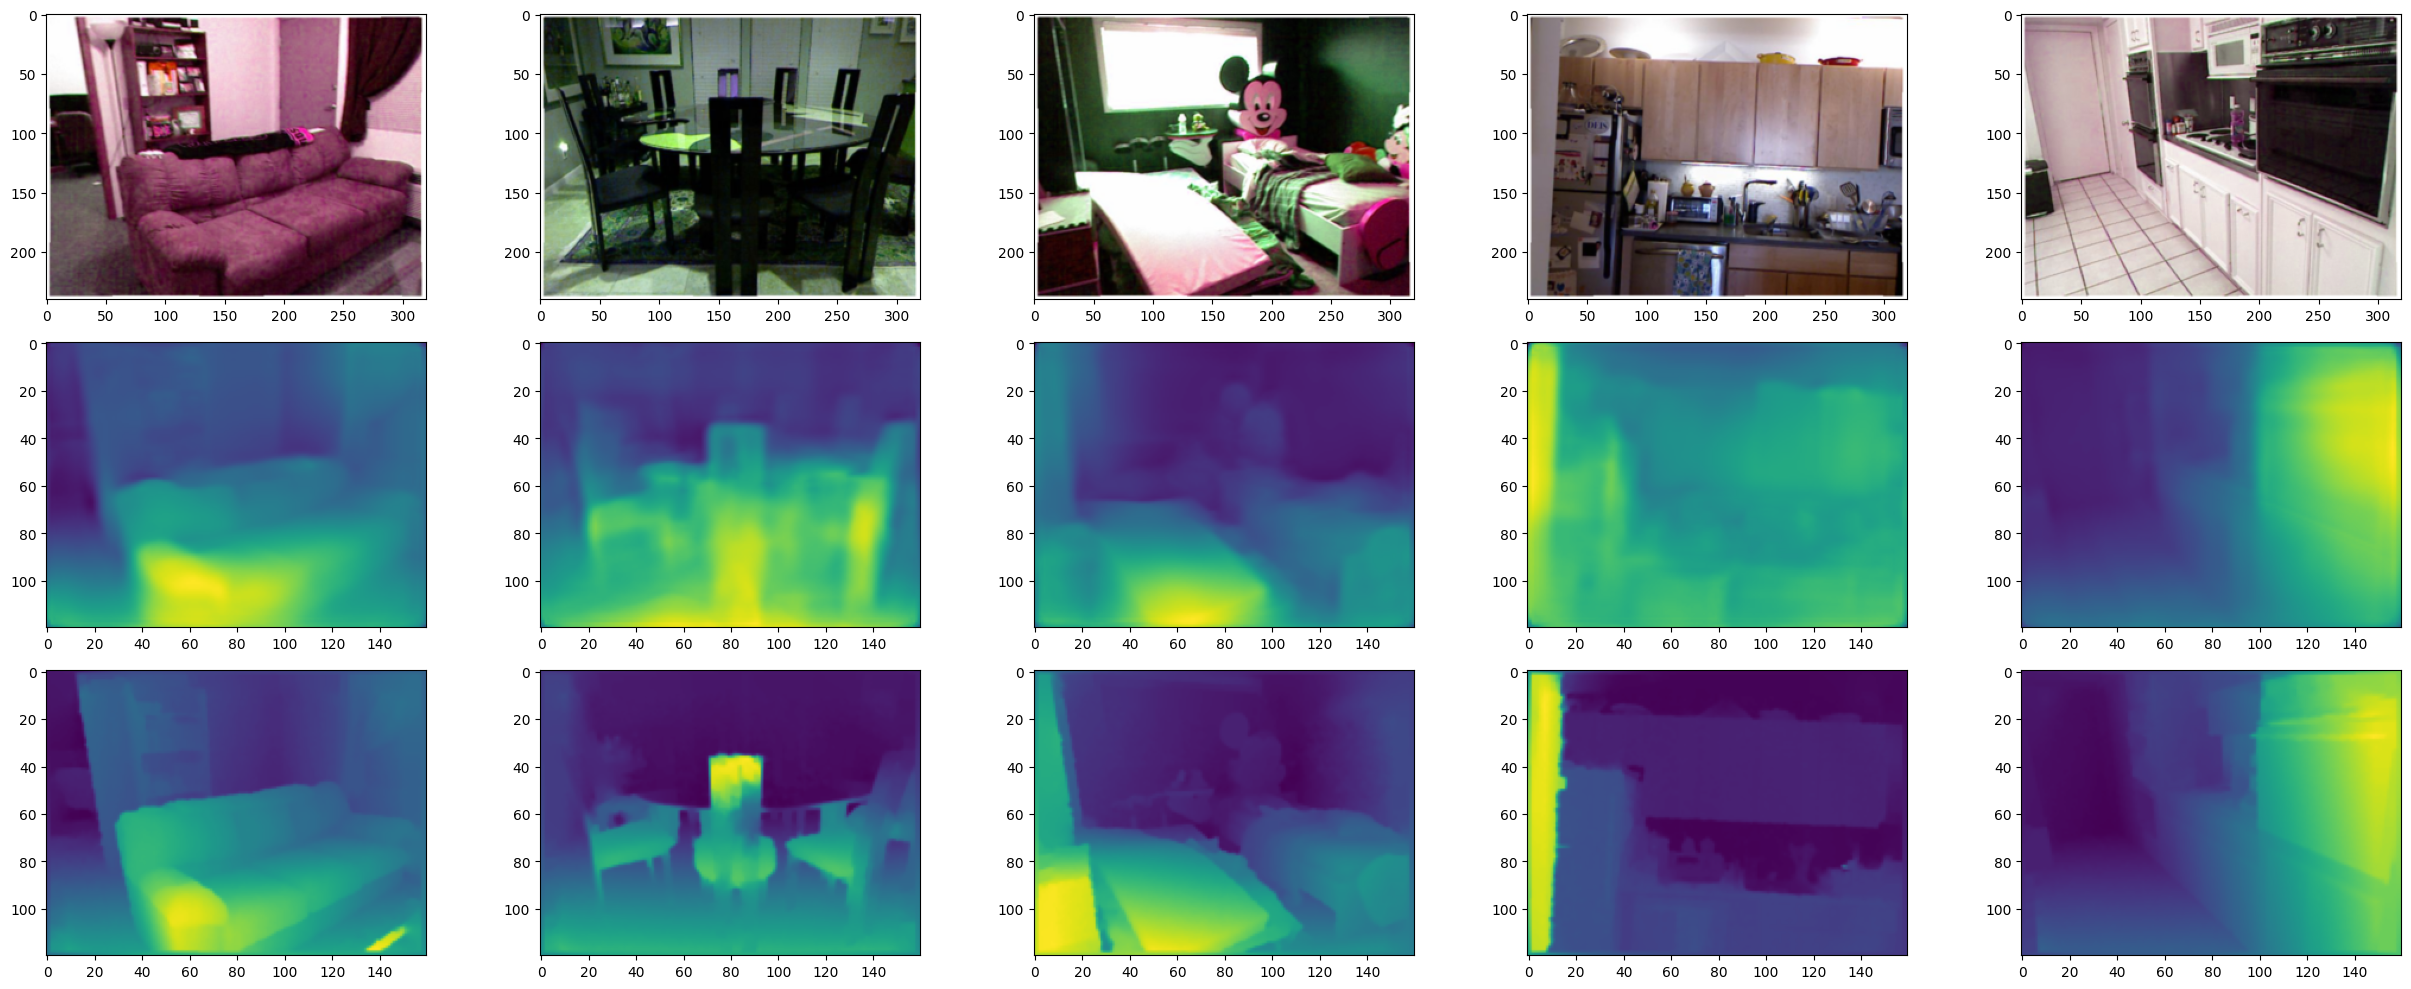

In [18]:
with torch.no_grad():
    model.eval()

    N = 5

    fig, axs = plt.subplots(3, N, figsize=(5*N, 10))

    i = 0
    for img, lbl in train_visualizer:
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)

        # lbl = 1.0 / lbl
        
        pred = model(img)

        img = img[0]
        pred = pred[0]
        lbl = lbl[0]

        axs[0, i].imshow(img.cpu().permute(1, 2, 0))
        axs[1, i].imshow(pred.cpu().permute(1, 2, 0))
        axs[2, i].imshow(lbl.cpu().permute(1, 2, 0))

        i += 1
        if i == 5:
            break

    plt.tight_layout()
    plt.show()

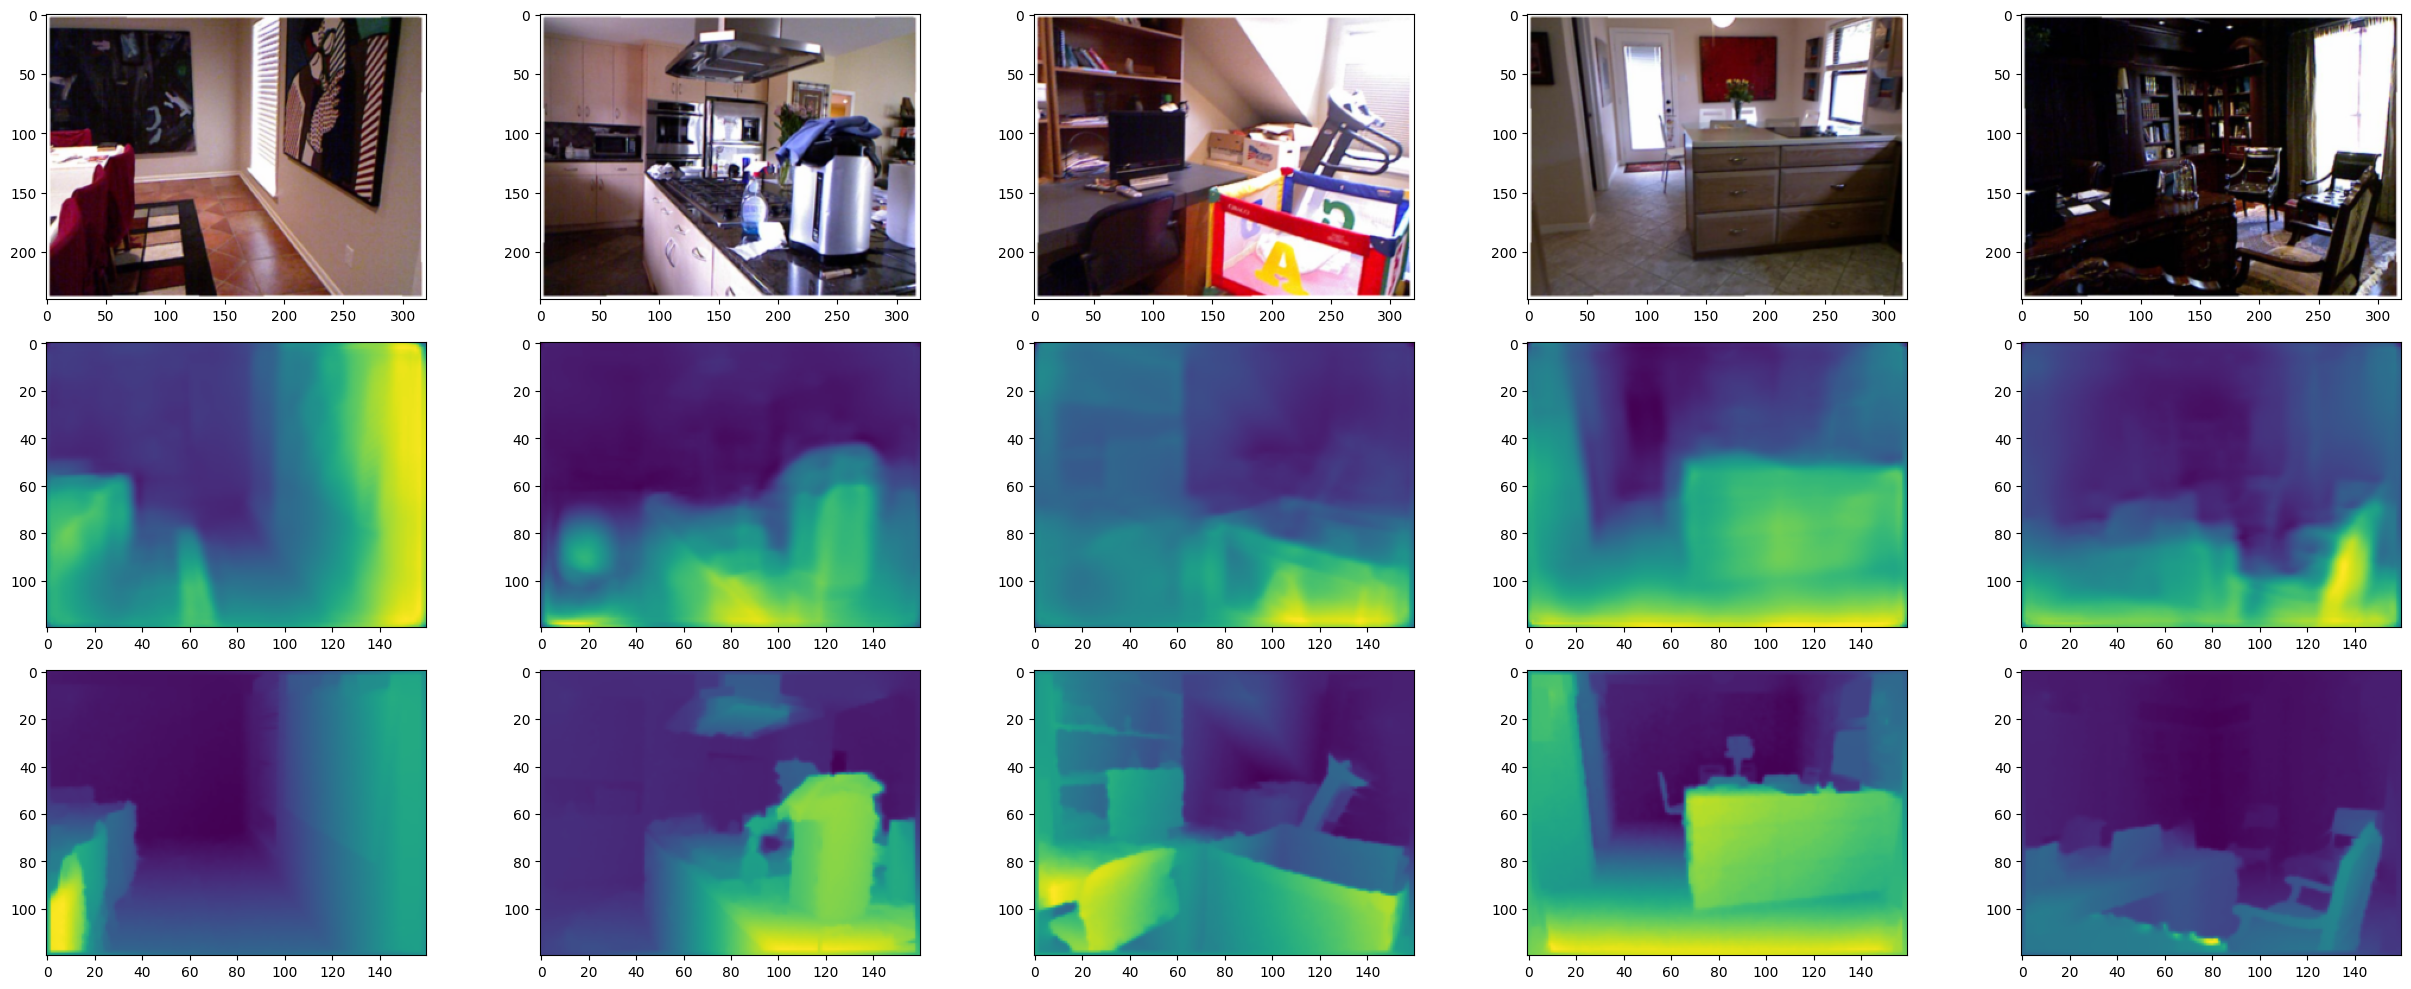

In [19]:
with torch.no_grad():
    model.eval()

    N = 5

    fig, axs = plt.subplots(3, N, figsize=(5*N, 10))

    i = 0
    for img, lbl in test_visualizer:
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)

        # lbl = 1000.0 / lbl
        pred = model(img)

        img = img[0]
        pred = pred[0]
        lbl = lbl[0]

        axs[0, i].imshow(img.cpu().permute(1, 2, 0))
        axs[1, i].imshow(pred.cpu().permute(1, 2, 0))
        axs[2, i].imshow(lbl.cpu().permute(1, 2, 0))

        i += 1
        if i == 5:
            break

    plt.tight_layout()
    plt.show()

In [ ]:
model.eval()

total_test_loss = 0
total_rel = 0
total_rmse = 0
total_ale = 0

for img, lbl in tqdm(test_dataloader):
    with torch.no_grad():

        img, lbl = img.to(DEVICE), lbl.to(DEVICE)

        pred = model(img)

        loss = Loss_fn(pred, lbl, 0.1, 1, 1)
        total_test_loss += loss.item()

        total_rel += functions.mean_relative_error(pred, lbl)
        total_rmse += functions.root_mean_squared_error(pred, lbl)
        total_ale += functions.average_log_error(pred, lbl)


avg_test_loss = total_test_loss / len(test_dataloader)
print("test_loss:", avg_test_loss)

avg_rel = total_rel / len(test_dataloader)
print("avg_rel:", avg_rel)

avg_rmse = total_rmse / len(test_dataloader)
print("avg_rmse:", avg_rmse)

avg_ale = total_ale / len(test_dataloader)
print("avg_ale:", avg_ale)

  0%|          | 0/55 [00:00<?, ?it/s]

test_loss: 0.08302422287789259
avg_rel: 0.31362724
avg_rmse: 0.113915384
avg_ale: 0.27185962


In [13]:
!ls

CustomDataset.py			     notebook.ipynb
CustomLoss.py				     nyu_depth_v2_labeled.mat
last_best_model_normalized_inverse_depth.pt  __pycache__
last_state.pt				     README.md
Models					     Utils


In [14]:
# torch.save(model.state_dict(), r"last_state.pt")

In [17]:
model.load_state_dict(torch.load("last_best_model_normalized_inverse_depth.pt"))

<All keys matched successfully>